# 结构详解与代码实现

本节内容来自 [徒手实现多层感知器--如何优化模型训练](https://www.bilibili.com/video/BV1dw4m1v7KG) 。

模型的参数更新公式可以简写为：

$a_{k+1} = a_k - \eta \frac{\partial L}{\partial a}$

当梯度接近于 0 时，模型的更新速度变的很慢。

激活函数过热：

![](images/激活函数过热.png)

$$
\begin{aligned}
i_2^1 &= w_{1,2}^1 x_1 + w_{2,2}^1 x_2 + b_2^1 \\
o_2^1 &= \text{sigmoid}(i_2^1) = \frac{1}{1 + e^{-i_2^1}}
\end{aligned}
\quad
\longrightarrow
\quad
\frac{\partial L}{\partial w_{1,2}^1} = \frac{\partial L}{\partial o_2^1} \times \underbrace{\frac{do_2^1}{di_2^1}}_{\text{激活函数的导数}} \times \frac{\partial i_2^1}{\partial w_{1,2}^1}
$$

梯度消失（深度越深，越难训练）：

![](images/梯度消失.png)

$$
\frac{\partial L}{\partial w_4} = \frac{\partial L}{\partial i_4} o_3,
\quad
\frac{\partial L}{\partial w_3} = \frac{\partial L}{\partial i_4} w_4 g(i_3) o_2,
\quad
\ldots,
\quad
\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial i_4} w_4 g(i_3) w_3 g(i_2) w_2 g(i_1) x
$$



In [1]:
import torch
import torch.nn.functional as F
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

torch.manual_seed(1024)

In [2]:
# 定义线性模型和Sigmoid函数

class Linear:

    def __init__(self, in_features, out_features, bias=True):
        '''
        模型参数初始化
        需要注意的是，此次故意没做参数初始化的优化
        '''
        self.weight = torch.randn((in_features, out_features), requires_grad=True)   # (in_features, out_features)
        self.bias = torch.randn(out_features, requires_grad=True) if bias else None  # (             out_features)

    def __call__(self, x):
        #           x: (B, in_features)
        # self.weight:    (in_features, out_features)
        self.out = x @ self.weight  # (B, out_features)
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        '''
        返回线性模型的参数，主要用于参数迭代更新
        由于PyTorch的计算单元就是张量，
        所以此次只需将不同参数简单合并成列表即可
        '''
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]


class Sigmoid:

    def __call__(self, x):
        self.out = torch.sigmoid(x)
        return self.out

    def parameters(self):
        '''
        Sigmoid函数没有模型参数
        '''
        return []

In [3]:
class Sequential:

    def __init__(self, layers):
        # layers表示的模型组件，比如线性模型，比如sigmoid
        self.layers = layers

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [4]:
def train_model(model, data, max_steps):
    lossi = []
    # 记录各层的参数更新幅度
    # {1: [...], 2: [...]}
    udi = {}
    x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])
    learning_rate = 0.01

    for i in range(max_steps):
        # 向前传播
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        # 保留中间节点的梯度，以便观察
        for layer in model.layers:
            layer.out.retain_grad()
        for p in model.parameters():
            p.grad = None
        # 反向传播
        loss.backward()
        # 更新模型参数
        with torch.no_grad():
            for i, p in enumerate(model.parameters()):
                p -= learning_rate * p.grad
                udi[i] = udi.get(i, []) + [(learning_rate * p.grad).std() / p.std()]  # 标准差比值
        lossi.append(loss.item())
    return lossi, udi

In [5]:
data = make_moons(2000, noise=0.05)

# 为了讨论的方便，将神经网络扩大
n_hidden = 100
model = Sequential([
    Linear(       2, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden,        2)
])

train_model(model, data, 1)

([0.9094887375831604],
 {0: [tensor(0.0007)],
  1: [tensor(0.0009)],
  2: [tensor(0.0003)],
  3: [tensor(0.0004)],
  4: [tensor(0.0002)],
  5: [tensor(0.0004)],
  6: [tensor(0.0002)],
  7: [tensor(0.0004)],
  8: [tensor(0.0020)],
  9: [tensor(0.0040)]})

In [7]:
import torch

x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x * 2
z = y ** 2
loss = z.sum()

# 必须对非叶张量 y 调用 retain_grad()
y.retain_grad()  # 保留中间参数的提付

loss.backward()

print("y.grad =", y.grad)  # 输出：tensor([4., 8., 12.])
print("x.grad =", x.grad)  # 输出：tensor([4., 8., 12.])

y.grad = None
x.grad = tensor([ 8., 16., 24.])


C:\Users\lovep\AppData\Local\Temp\ipykernel_33356\2318987494.py:12: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  print("y.grad =", y.grad)  # 输出：tensor([4., 8., 12.])


In [9]:
# 监控激活函数的输出
def saturation_stats(model):
    for i, layer in enumerate(model.layers):
        if isinstance(layer, Sigmoid):
            t = layer.out
            # 当激活函数输出大于 0.99 或小于 0.01 的时候，认为激活函数过热
            # 计算过热比例
            saturation = ((t - 0.5).abs() > 0.49).float().mean()
            # 激活函数的输出分布情况
            hy, hx = torch.histogram(t, density=True)  # 计算张量中数据的直方图，density 是否归一化
            plt.plot(hx[:-1].detach(), hy.detach())
            print(f'layer {i} mean {t.mean():.2f} std {t.std():.2f} saturation {saturation:.2f}')

    plt.show()

layer 1 mean 0.51 std 0.27 saturation 0.01
layer 3 mean 0.52 std 0.42 saturation 0.38
layer 5 mean 0.41 std 0.43 saturation 0.45
layer 7 mean 0.54 std 0.41 saturation 0.38


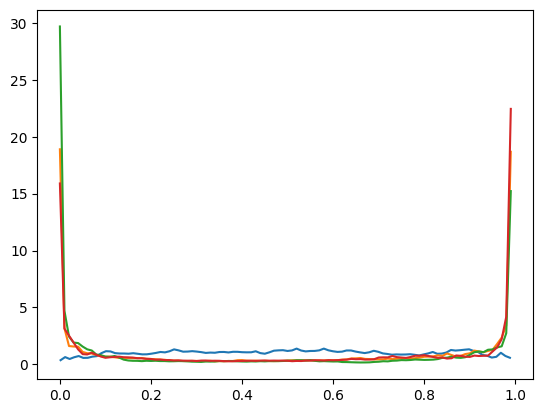

In [10]:
saturation_stats(model)

In [11]:
def grad_stats(model):
    # 输出层暂不讨论
    for i, layer in enumerate(model.layers[:-1]):
        if isinstance(layer, Linear):
            w = layer.parameters()[0]
            g = w.grad
            grad_ratio = g.std() / w.std()
            # 参数梯度的分布情况
            hy, hx = torch.histogram(g, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            print(f'layer {i} mean {g.mean():.2f} std {g.std():.2f} grad_ratio {grad_ratio:.2f}')
    plt.show()

layer 0 mean 0.00 std 0.08 grad_ratio 0.07
layer 2 mean 0.00 std 0.03 grad_ratio 0.03
layer 4 mean 0.00 std 0.02 grad_ratio 0.02
layer 6 mean 0.00 std 0.02 grad_ratio 0.02


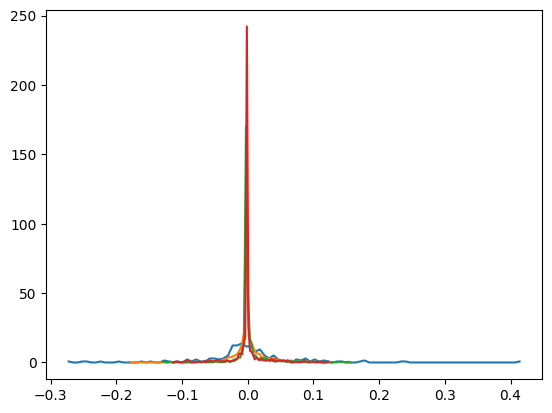

In [12]:
grad_stats(model)

In [13]:
_, ud = train_model(model, data, 100)

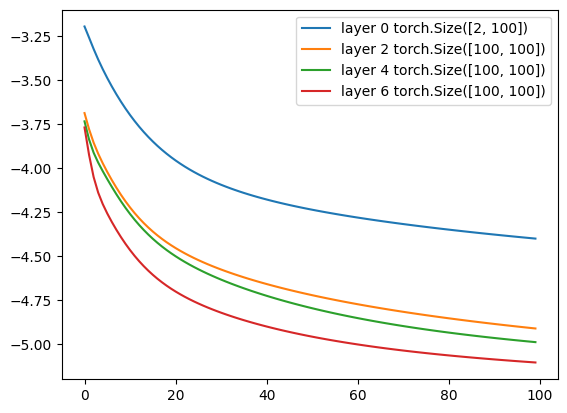

In [16]:
def grad_ratio_plot(model):
    legends = []
    for i, p in enumerate(model.parameters()[:-2]):
        if p.ndim == 2:  # 维度数
            plt.plot([t.log10().item() for t in ud[i]])
            legends.append(f'layer {i} {p.shape}')
    plt.legend(legends)
    plt.show()

grad_ratio_plot(model)

# 新激活函数

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

$$
\text{ReLU}(x) = \max(0, x)
$$

In [17]:
data = make_moons(2000, noise=0.05)

# 为了讨论的方便，将神经网络扩大
n_hidden = 100
model = Sequential([
    Linear(       2, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden), Sigmoid(),
    Linear(n_hidden,        2)
])

# 参数初始化的优化
with torch.no_grad():
    for layer in model.layers:
        if isinstance(layer, Linear):
            in_features, out_features = layer.weight.shape
            layer.weight *= 1 / in_features ** 0.5  # 参数优化要看激活函数
            layer.bias = torch.zeros(out_features, requires_grad=True)

train_model(model, data, 1)

([0.7257911562919617],
 {0: [tensor(1.3399e-06)],
  1: [tensor(1.)],
  2: [tensor(1.5735e-05)],
  3: [tensor(1.)],
  4: [tensor(5.3856e-05)],
  5: [tensor(1.)],
  6: [tensor(0.0002)],
  7: [tensor(1.)],
  8: [tensor(0.0068)],
  9: [tensor(1.)]})

layer 1 mean 0.49 std 0.17 saturation 0.00
layer 3 mean 0.50 std 0.12 saturation 0.00
layer 5 mean 0.49 std 0.12 saturation 0.00
layer 7 mean 0.50 std 0.11 saturation 0.00


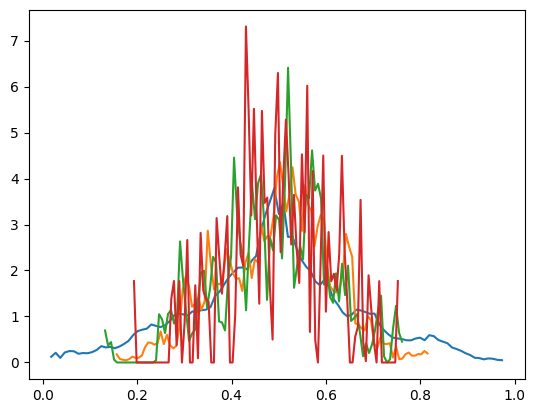

In [18]:
saturation_stats(model)

In [25]:
@torch.no_grad()
def layer_stats(func, calculate_gain):
    x = torch.randn(300, 1000)
    for t in range(10):
        l = Linear(1000, 1000, bias=False)
        in_features, _ = l.weight.shape
        # 初步优化
        l.weight *= 1 / in_features ** 0.5
        # 系数扩大
        l.weight *= calculate_gain
        x = func(l(x))
        hy, hx = torch.histogram(x, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        print(f'layer {t} mean {x.mean():.2f} std {x.std():.2f}')

layer 0 mean 0.50 std 0.21
layer 1 mean 0.50 std 0.13
layer 2 mean 0.50 std 0.12
layer 3 mean 0.51 std 0.12
layer 4 mean 0.50 std 0.12
layer 5 mean 0.51 std 0.12
layer 6 mean 0.50 std 0.12
layer 7 mean 0.50 std 0.12
layer 8 mean 0.50 std 0.12
layer 9 mean 0.50 std 0.12


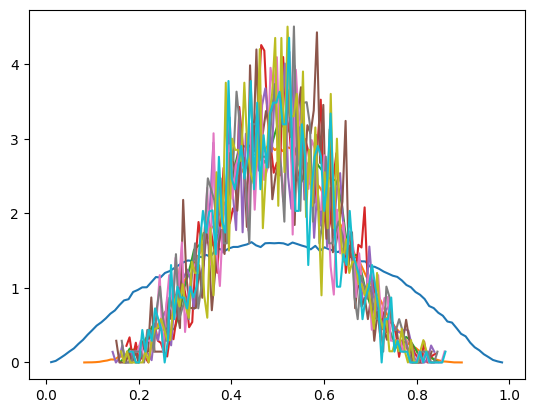

In [24]:
layer_stats(torch.sigmoid, 1.0)

layer 0 mean -0.00 std 0.63
layer 1 mean 0.00 std 0.49
layer 2 mean 0.00 std 0.41
layer 3 mean -0.00 std 0.36
layer 4 mean 0.00 std 0.32
layer 5 mean 0.00 std 0.29
layer 6 mean 0.00 std 0.27
layer 7 mean 0.00 std 0.26
layer 8 mean 0.00 std 0.24
layer 9 mean -0.00 std 0.23


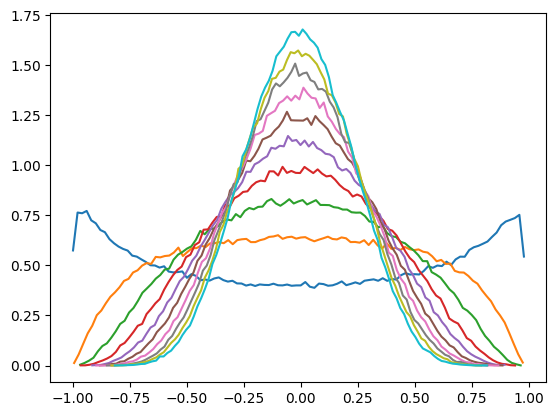

In [26]:
layer_stats(torch.tanh, 1.0)

layer 0 mean 0.00 std 0.76
layer 1 mean -0.00 std 0.69
layer 2 mean -0.00 std 0.67
layer 3 mean -0.00 std 0.66
layer 4 mean 0.00 std 0.65
layer 5 mean -0.00 std 0.65
layer 6 mean 0.00 std 0.65
layer 7 mean 0.00 std 0.65
layer 8 mean -0.00 std 0.65
layer 9 mean 0.00 std 0.65


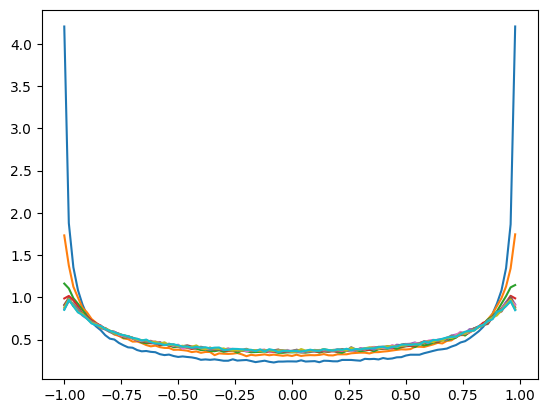

In [27]:
layer_stats(torch.tanh, 5 / 3)

layer 0 mean 0.56 std 0.83
layer 1 mean 0.56 std 0.83
layer 2 mean 0.58 std 0.84
layer 3 mean 0.57 std 0.85
layer 4 mean 0.58 std 0.84
layer 5 mean 0.57 std 0.84
layer 6 mean 0.57 std 0.84
layer 7 mean 0.57 std 0.83
layer 8 mean 0.55 std 0.80
layer 9 mean 0.59 std 0.82


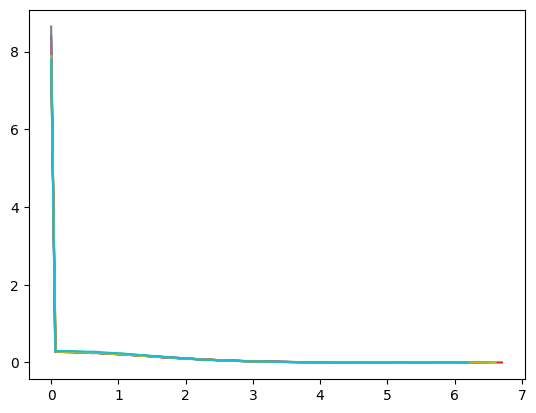

In [30]:
layer_stats(torch.relu, torch.tensor(2).sqrt())

In [31]:
# 对网格输出批量归一化，和 AlexNet 中有提及，这个归一化仅在训练时做，并且批输入不允许是1。否则会报错，所以需要额外的代码来判断是出于训练状态还是推理状态
class BatchNorm1d:
    # x: ()B, f

    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        self.gamma = torch.ones(dim, requires_grad=True)  # (f)
        self.beta = torch.zeros(dim, requires_grad=True)  # (f)

    def __call__(self, x):
        # x: (B, f)
        xmean = x.mean(0, keepdim=True)  # (1, f)
        xvar = x.var(0, keepdim=True) # (1, f)  方差
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)   # (B, f)
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [32]:
@torch.no_grad()
def layer_stats2(func):
    x = torch.randn(300, 1000)
    for t in range(10):
        l = Linear(1000, 1000, bias=False)
        b = BatchNorm1d(1000)
        #in_features, _ = l.weight.shape
        # 初步优化
        #l.weight *= 1 / in_features ** 0.5
        # 做进一步的优化
        #l.weight *= calculate_gain
        x = func(b(l(x)))
        hy, hx = torch.histogram(x, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        print(f'layer {t} mean {x.mean():.2f} std {x.std():.2f}')

layer 0 mean 0.40 std 0.58
layer 1 mean 0.40 std 0.58
layer 2 mean 0.40 std 0.58
layer 3 mean 0.40 std 0.58
layer 4 mean 0.40 std 0.58
layer 5 mean 0.40 std 0.58
layer 6 mean 0.40 std 0.58
layer 7 mean 0.40 std 0.58
layer 8 mean 0.40 std 0.58
layer 9 mean 0.40 std 0.58


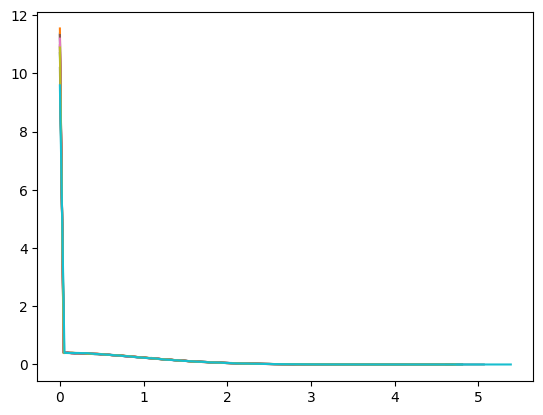

In [33]:
layer_stats2(torch.relu)

In [34]:
n_hidden = 100
model = Sequential([
    Linear(       2, n_hidden, bias=False), BatchNorm1d(n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Sigmoid(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Sigmoid(),
    Linear(n_hidden,        2)
])

# 参数初始化的优化
with torch.no_grad():
    for layer in model.layers:
        if isinstance(layer, Linear):
            in_features, out_features = layer.weight.shape
            layer.weight *= 1 / in_features ** 0.5

train_model(model, data, 1)

([0.7717537879943848],
 {0: [tensor(0.0054)],
  1: [tensor(1.0000)],
  2: [tensor(1.)],
  3: [tensor(0.0086)],
  4: [tensor(1.0000)],
  5: [tensor(1.)],
  6: [tensor(0.0018)],
  7: [tensor(1.0001)],
  8: [tensor(1.)],
  9: [tensor(0.0011)],
  10: [tensor(1.0000)],
  11: [tensor(1.)],
  12: [tensor(0.0080)],
  13: [tensor(0.0019)]})

In [36]:
# 层归一化
class LayerNorm1d:
    # x : (B, f)

    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        self.gamma = torch.ones(dim, requires_grad=True)  # (f)
        self.beta = torch.zeros(dim, requires_grad=True)  # (f)

    def __call__(self, x):
        # x : (B, f)
        xmean = x.mean(1, keepdim=True)  # (B, 1)
        xvar = x.var(1, keepdim=True)    # (B, 1)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # (B, f)
        self.out = self.gamma * xhat + self.beta  # (B, f)
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [37]:
@torch.no_grad()
def layer_stats3(func):
    x = torch.randn(300, 1000)
    for t in range(10):
        l = Linear(1000, 1000, bias=False)
        b = LayerNorm1d(1000)
        #in_features, _ = l.weight.shape
        # 初步优化
        #l.weight *= 1 / in_features ** 0.5
        # 做进一步的优化
        #l.weight *= calculate_gain
        x = func(b(l(x)))
        hy, hx = torch.histogram(x, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        print(f'layer {t} mean {x.mean():.2f} std {x.std():.2f}')

layer 0 mean 0.50 std 0.21
layer 1 mean 0.50 std 0.21
layer 2 mean 0.50 std 0.21
layer 3 mean 0.50 std 0.21
layer 4 mean 0.50 std 0.21
layer 5 mean 0.50 std 0.21
layer 6 mean 0.50 std 0.21
layer 7 mean 0.50 std 0.21
layer 8 mean 0.50 std 0.21
layer 9 mean 0.50 std 0.21


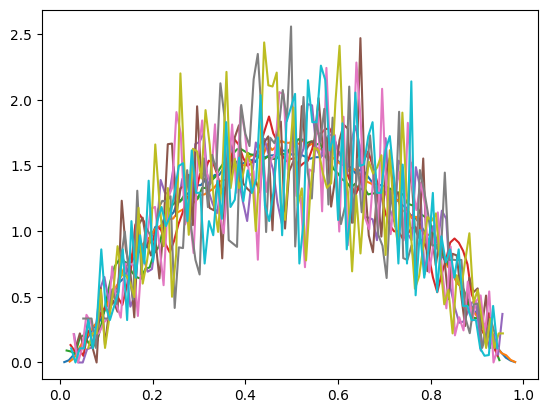

In [38]:
layer_stats3(torch.sigmoid)

In [43]:
m1 = torch.tensor(range(0, 6)).float().view(-1, 2)
m2 = torch.tensor(range(6, 12)).float().view(2, -1)
print(m1)
print(m1.mean(dim=0))


tensor([[0., 1.],
        [2., 3.],
        [4., 5.]])
tensor([2., 3.])
